<a href="https://colab.research.google.com/github/upinder-sangha/Image-Captioning/blob/main/COMP_6341_CV_PROJECT_PHASE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Testing the trained Model

##Importing useful modules and functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp drive/MyDrive/COMP_6341_CV_PROJECT/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k
! unzip flickr8k.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

##Importing data and saved model from previous phase

In [ ]:
!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES/captions.pkl /content
!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES/features.pkl /content

features = pickle.load(open("features.pkl","rb"))
captions = pickle.load(open("captions.pkl","rb"))

In [ ]:
!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES//test_features.pkl /content
!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES//test_captions.pkl /content

test_features = pickle.load(open("test_features.pkl","rb"))
test_captions = pickle.load(open("test_captions.pkl","rb"))

print("size of test set = ", len(test_captions))

size of test set =  971


In [ ]:
!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES//tokenizer.pkl /content
tokenizer = pickle.load(open("tokenizer.pkl","rb"))
index_to_word = {v: k for k, v in tokenizer.word_index.items()}

!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES//max_length.pkl /content
max_length = pickle.load(open("max_length.pkl","rb"))

In [ ]:
from tensorflow import keras
!cp drive/MyDrive/COMP_6341_CV_PROJECT_RES/model-ep10.h5 /content
model = keras.models.load_model('model-ep10.h5')

##Testing the model on a single image in the dataset

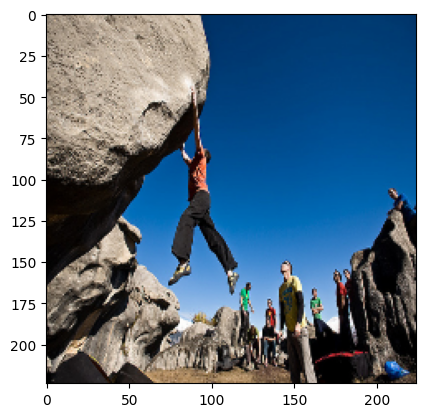

In [ ]:
image = plt.imread('Images/2844846111_8c1cbfc75d.jpg')
image = cv2.resize(image,(224,224))
plt.imshow(image)

In [ ]:
captions['2844846111_8c1cbfc75d']

['a man climber a large rock without any gear while his friends watch',
 'a person climbing a rock while others are standing around and watching',
 'a person hangs off a large rock as other people watch',
 'a rock climber hangs from a ledge while others look on',
 'man dangling from rock as spectators watch']

In [ ]:

from numpy import argmax
from keras.utils import pad_sequences

def generate_caption(model, tokenizer, feature, max_length=22):
    # seed the generation process
    caption = 'start'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([feature,sequence], verbose=0)
        yhat = argmax(yhat)
        # map integer to word
        word = index_to_word[yhat]
        if word is None:
            break
        # append as input for generating the next word
        caption += ' ' + word
        if word == 'end':
            break
    return caption

In [ ]:
feature = features['2844846111_8c1cbfc75d']
# generate caption
caption = generate_caption(model, tokenizer, feature, max_length)
print(caption)

start a man in a blue shirt is climbing up a rock end


##Calculating BLEU score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# evaluate the skill of the model
def evaluate_model(model, captions, features, tokenizer, max_length):
    real_captions, generated_captions = list(), list()
    n=0;
    for key, caption_list in captions.items():
        print(n)
        n+=1
        # generate caption
        yhat = generate_caption(model, tokenizer, features[key], max_length)
        # store real_captions and generated_captions
        captions = [d.split() for d in caption_list]
        real_captions.append(captions)
        generated_captions.append(yhat.split())

    # calculate BLEU score
    bleu_1 = corpus_bleu(real_captions, generated_captions, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(real_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(real_captions, generated_captions, weights=(0.3, 0.3, 0.3, 0))
    bleu_4 = corpus_bleu(real_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))

    print('BLEU-1: ',bleu_1)
    print('BLEU-2: ',bleu_2)
    print('BLEU-3: ',bleu_3)
    print('BLEU-4: ',bleu_4)


evaluate_model(model, test_captions, test_features, tokenizer, max_length)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1009434119_febe49276a
2844846111_8c1cbfc75d